In [1]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
import numpy as np
from loader import load_def_sets
from neighborAnalysis import get_most_biased
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import string 
from sklearn.cluster import KMeans
import json
%matplotlib inline

In [2]:
def load_legacy_w2v_as_keyvecs(w2v_file, dim=50):
    vectors = None
    with open(w2v_file, 'r') as f:
        vectors = Word2VecKeyedVectors(dim)

        ws = []
        vs = []

        for line in f:
            vect = line.strip().rsplit()
            word = vect[0]
            vect = np.array([float(x) for x in vect[1:]])
            if(dim == len(vect)):
                ws.append(word)
                vs.append(vect)
        vectors.add_vectors(ws, vs, replace=True)
    return vectors


In [3]:
# From https://kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(wv, focus_words, label_words, classes):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in focus_words :
        tokens.append(wv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    colors = ['red','blue','green']

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],color=colors[classes[i]])
        if labels[i] in label_words:
            plt.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom',
                         weight='heavy')

    plt.show()


def preprocessWordVecs(wv):
    """
    Following Bolukbasi:
    - only use the 50,000 most frequent words
    - only lower-case words and phrases
    - consisting of fewer than 20 lower-case characters
        (discard upper-case, digits, punctuation)
    - normalize all word vectors
    """
    newWordVecs = {}
    allowed = set(string.ascii_lowercase + ' ' + '_')

    for word, idx in wv.key_to_index.items():
        vec = wv.get_vector(word)
        chars = set(word)
        if chars.issubset(allowed) and len(word.replace('_', '')) < 20:
            newWordVecs[word] = vec / np.linalg.norm(vec)

    return newWordVecs


def get_race_directions(classes, embed_dim, word_vectors):
    vects = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        if word not in word_vectors:
            raise ValueError(word)
        vects[i] = word_vectors[word]
    mean = vects.mean(0)

    directions = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        directions[i] = word_vectors[word] - mean
        directions[i] = directions[i] / np.linalg.norm(directions[i])
        
    return directions 

def generate_max_biased_words(vectors, directions, num_words):
    positive_words = {}
    negative_words = {}
    
    for i, c in enumerate(classes):
        positive_bias, negative_bias = get_most_biased(vectors, directions[i], n_biased=num_words)
        positive_words[c] = [x[0] for x in positive_bias]
        negative_words[c] = [x[0] for x in negative_bias]
    return positive_words, negative_words


def cluster(X1, random_state, y_true, num=2):
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    return max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct)))

In [4]:
def_sets = load_def_sets('data/vocab/race_attributes_optm.json')
wv_pt = load_legacy_w2v_as_keyvecs("data/data_vocab_race_pre_trained.w2v")
wv_hd = load_legacy_w2v_as_keyvecs("data/data_vocab_race_hard_debias.w2v")
targets = json.load(open('data/professions.json', 'r'))
targets = [x[0] for x in targets]

original_vectors = preprocessWordVecs(wv_pt)
debiased_vectors = preprocessWordVecs(wv_hd)
embed_dim = wv_pt.vector_size

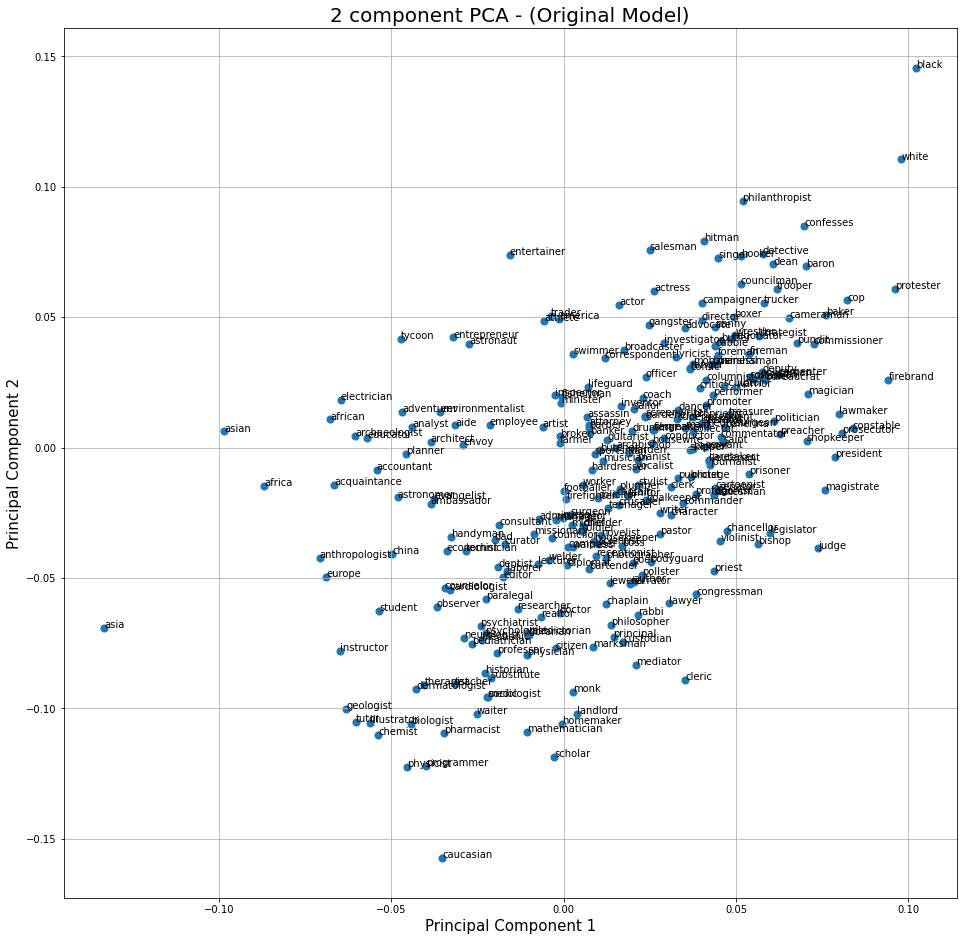

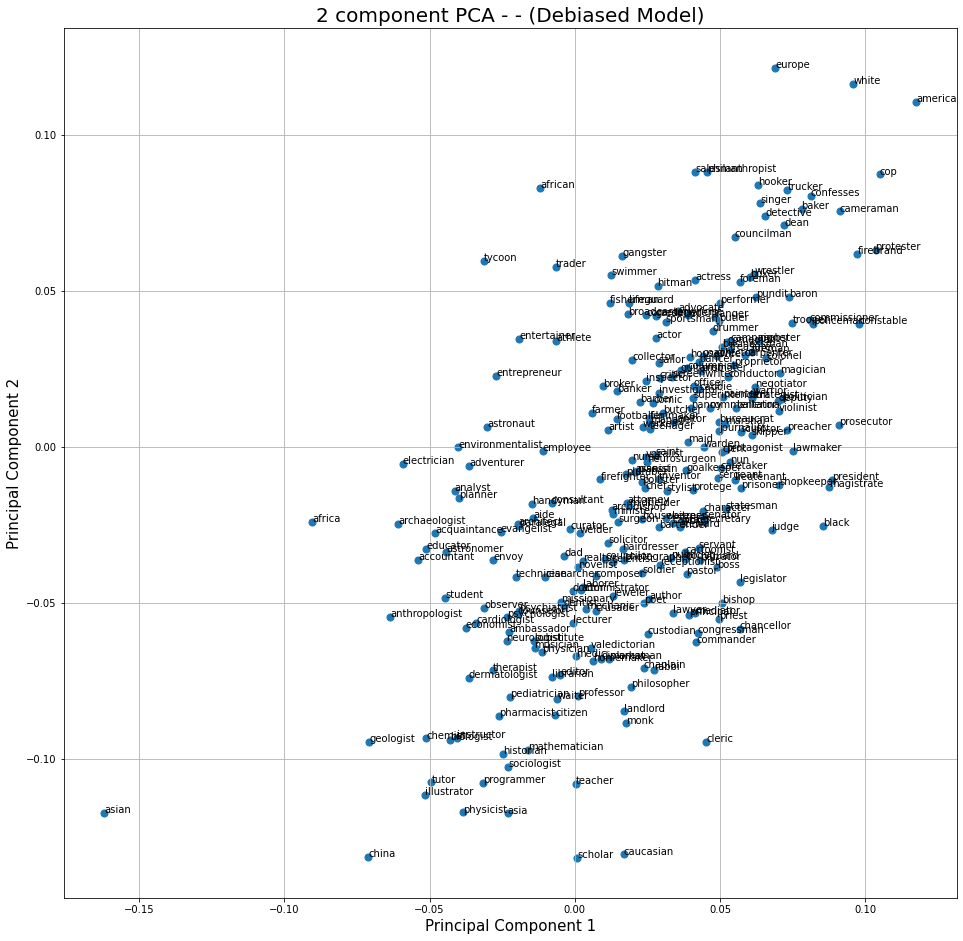

In [5]:
from biasOps import identify_bias_subspace, project_onto_subspace

# identify the race subspace used in debias method
subspace = identify_bias_subspace(original_vectors, def_sets, 2, embed_dim)

# compute bias for all definite words
target_bias = {}
target_bias_hd = {}

target_words = []

for word in targets:
    if word in original_vectors:    
        target_bias[word] = project_onto_subspace(original_vectors[word], subspace)
        target_words.append(word) 
    if word in debiased_vectors:
        target_bias_hd[word] = project_onto_subspace(debiased_vectors[word], subspace)
        target_words.append(word)    

for word in set([word for _, words in def_sets.items() for word in words]):
    if word in original_vectors:    
        target_bias[word] = project_onto_subspace(original_vectors[word], subspace) 
        target_words.append(word) 
    if word in debiased_vectors:
        target_bias_hd[word] = project_onto_subspace(debiased_vectors[word], subspace)
        target_words.append(word) 
        

# Do a PCA Plot to determine if any interesting trends exist in weights        
# Original Model PCA Plot

fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA - (Original Model)', fontsize = 20)

pca_1 = np.array([pca[0] for word, pca in target_bias.items()])
pca_2 = np.array([pca[1] for word, pca in target_bias.items()])
labels = [word for word, pca in target_bias.items()]

for i, txt in enumerate(labels):
    ax.annotate(txt, (pca_1[i], pca_2[i]))

ax.scatter(pca_1, pca_2, s = 50)
ax.grid()

# Hard Debias PCA Plot
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA - - (Debiased Model)', fontsize = 20)

pca_1 = np.array([pca[0] for word, pca in target_bias_hd.items()])
pca_2 = np.array([pca[1] for word, pca in target_bias_hd.items()])


labels = [word for word, pca in target_bias_hd.items()]

for i, txt in enumerate(labels):
    ax.annotate(txt, (pca_1[i], pca_2[i]))

ax.scatter(pca_1, pca_2, s = 50)
ax.grid()




tSNE Clustering Plot (Original Embedding): ['black', 'caucasian', 'asian']:


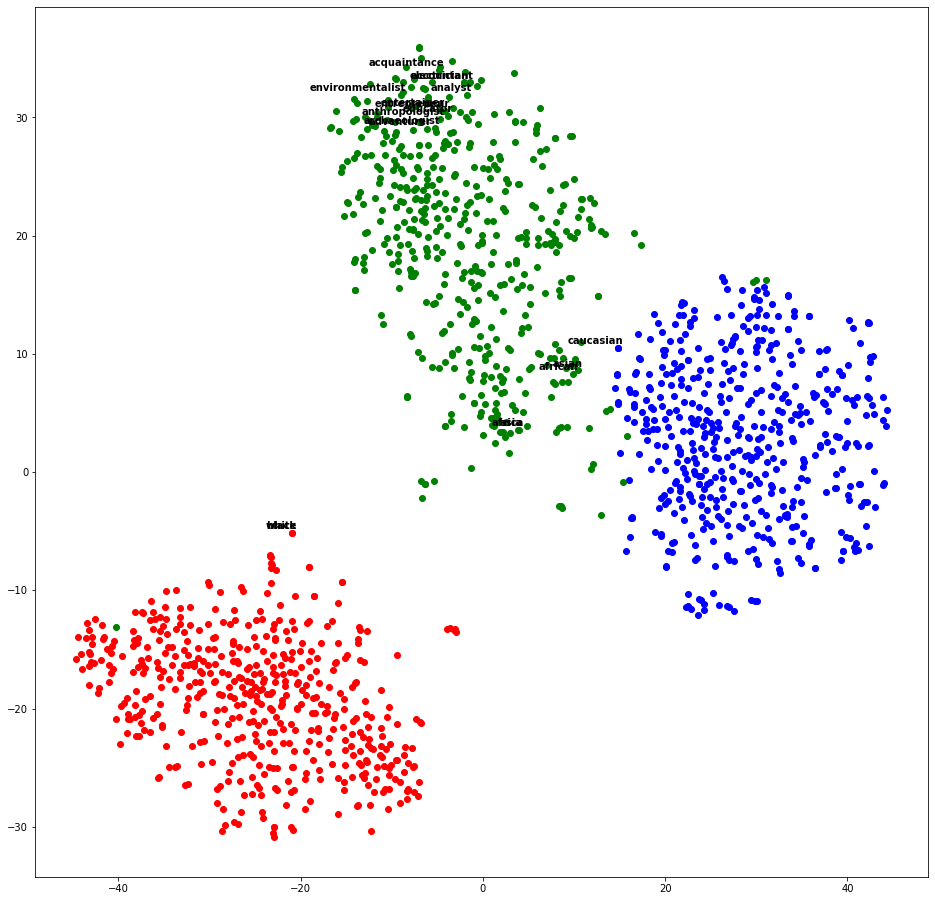

tSNE Clustering Plot (Hard Debiased Embedding): ['black', 'caucasian', 'asian']:


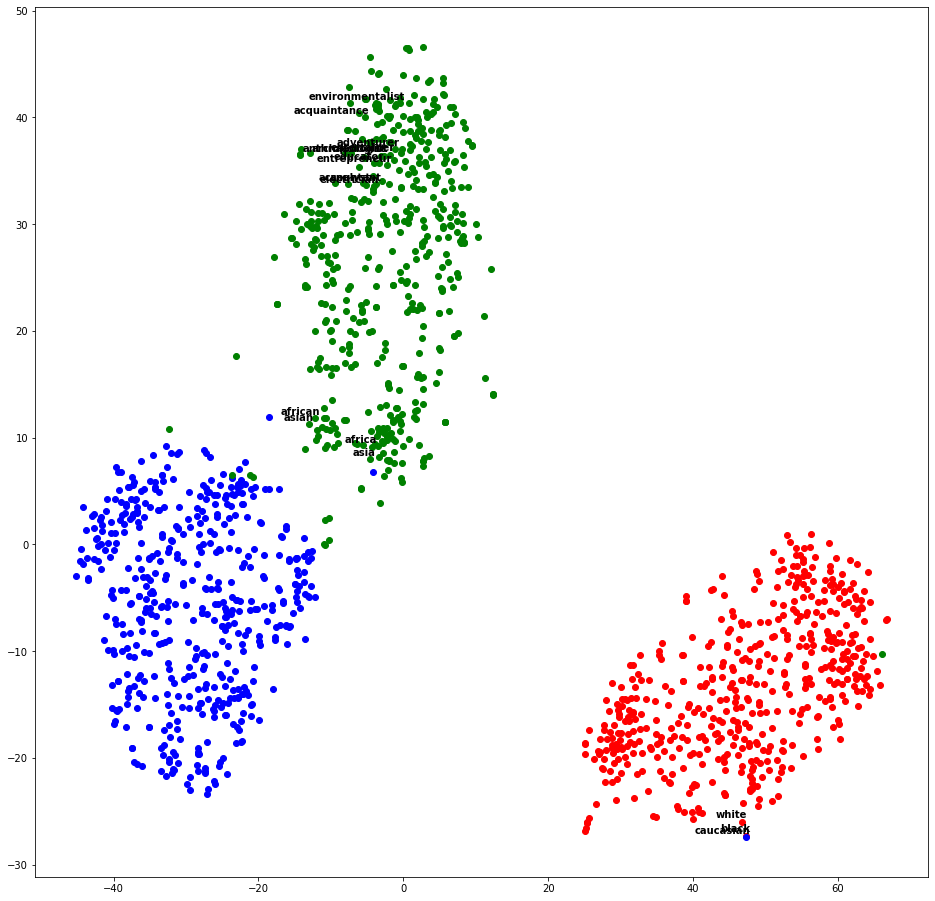


tSNE Clustering Plot (Original Embedding): ['african', 'caucasian', 'asian']:


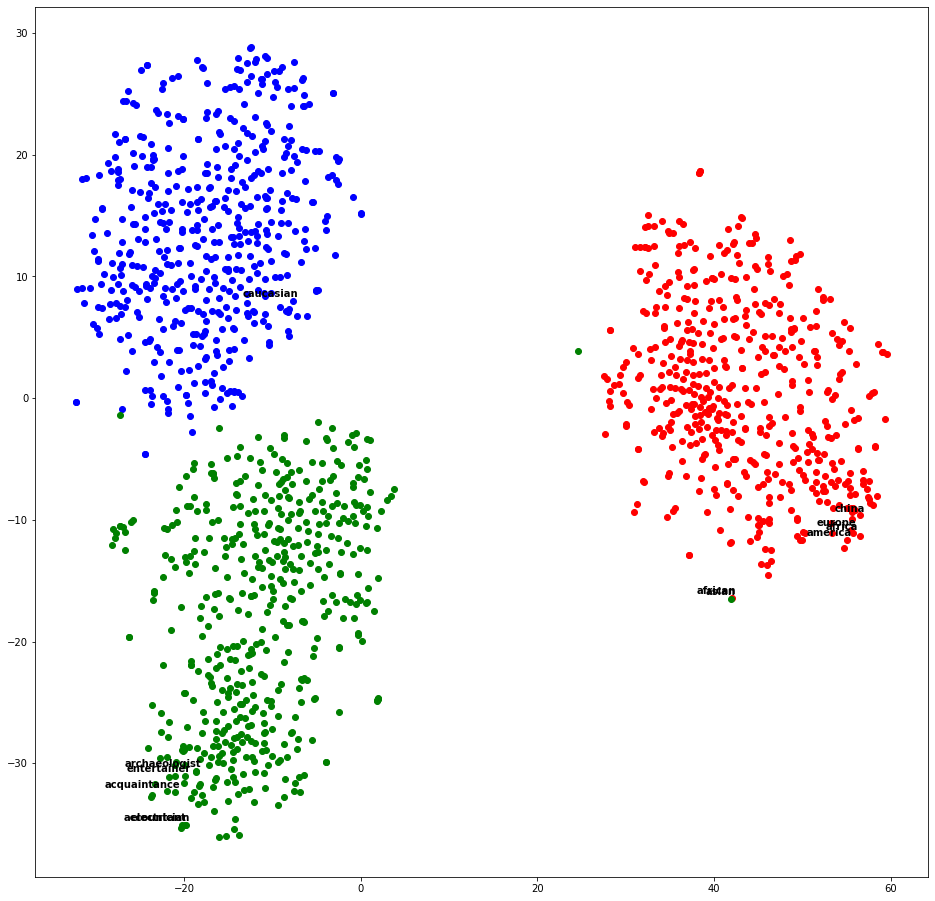

tSNE Clustering Plot (Hard Debiased Embedding): ['african', 'caucasian', 'asian']:


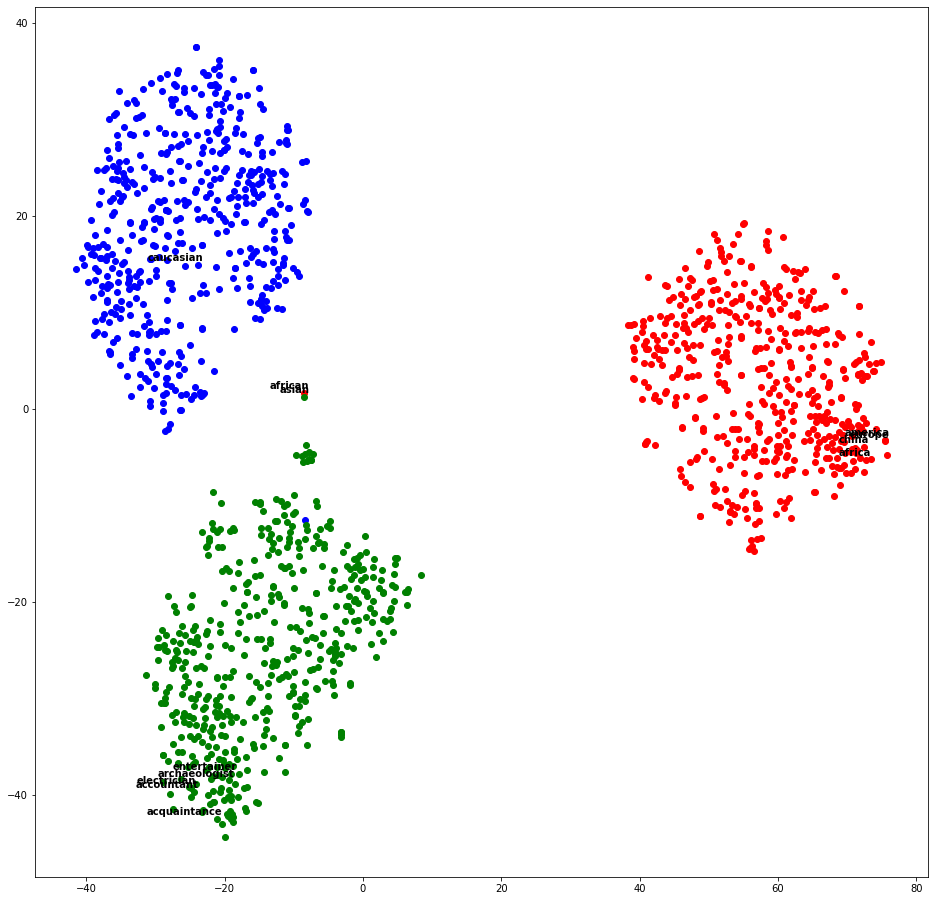


tSNE Clustering Plot (Original Embedding): ['black', 'white', 'asian']:


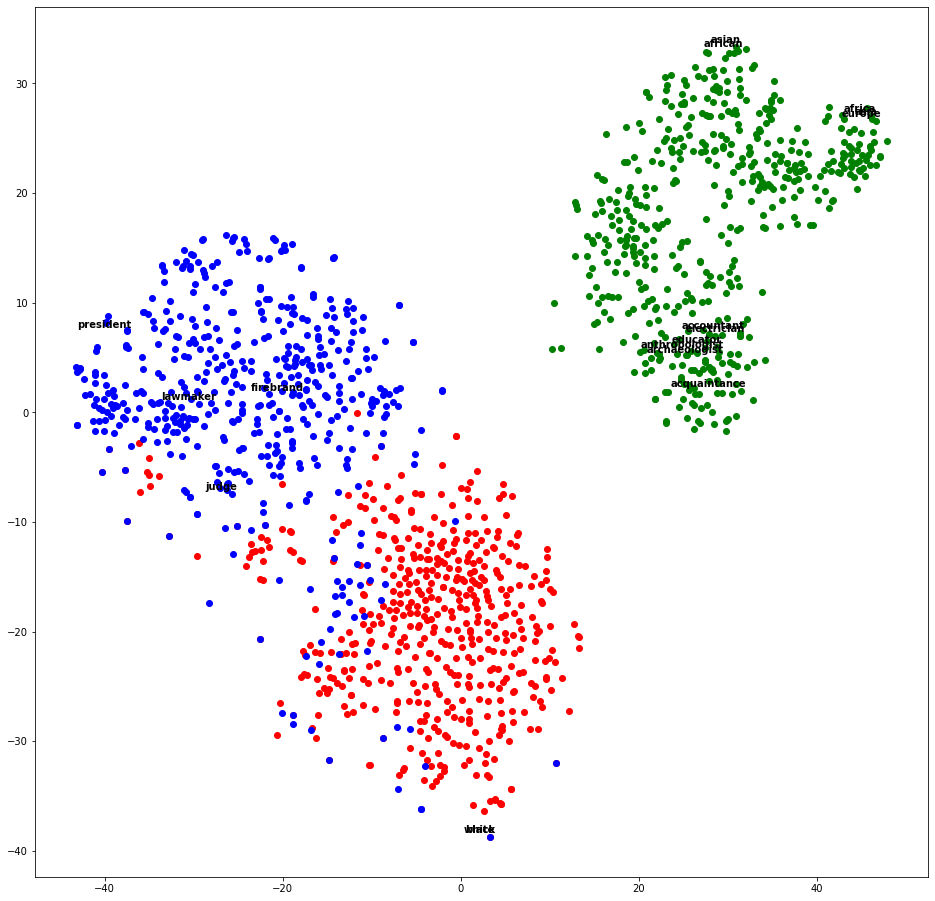

tSNE Clustering Plot (Hard Debiased Embedding): ['black', 'white', 'asian']:


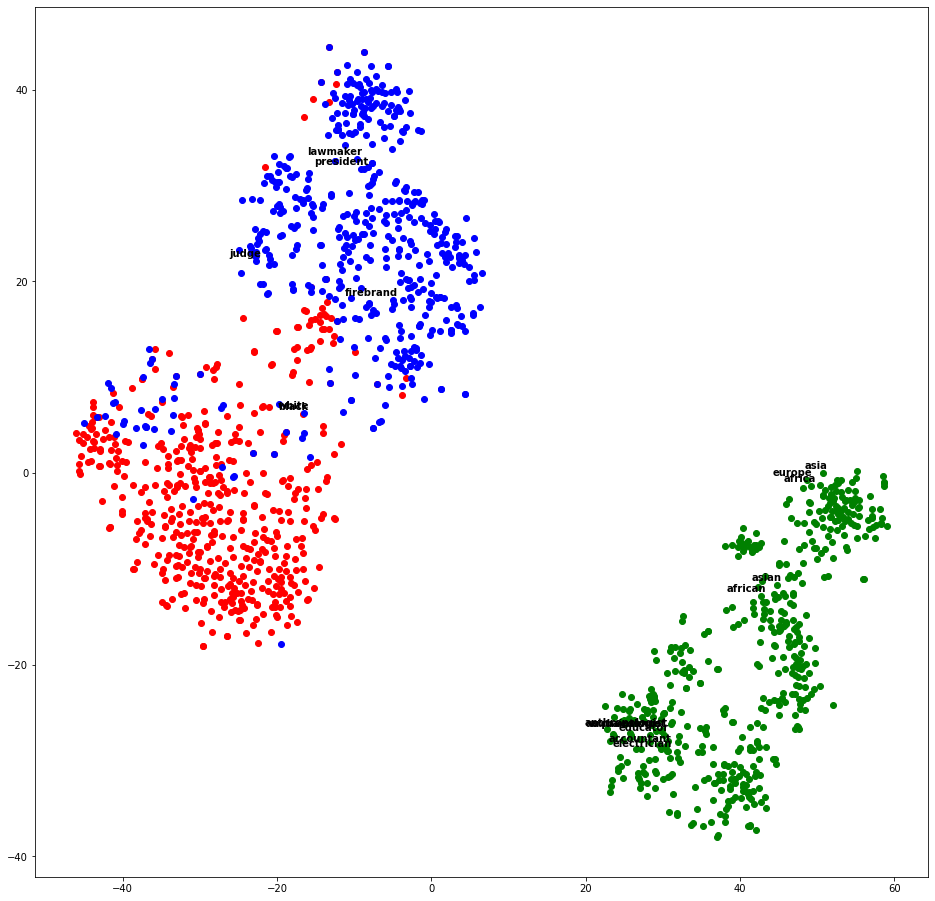


tSNE Clustering Plot (Original Embedding): ['africa', 'america', 'asia']:


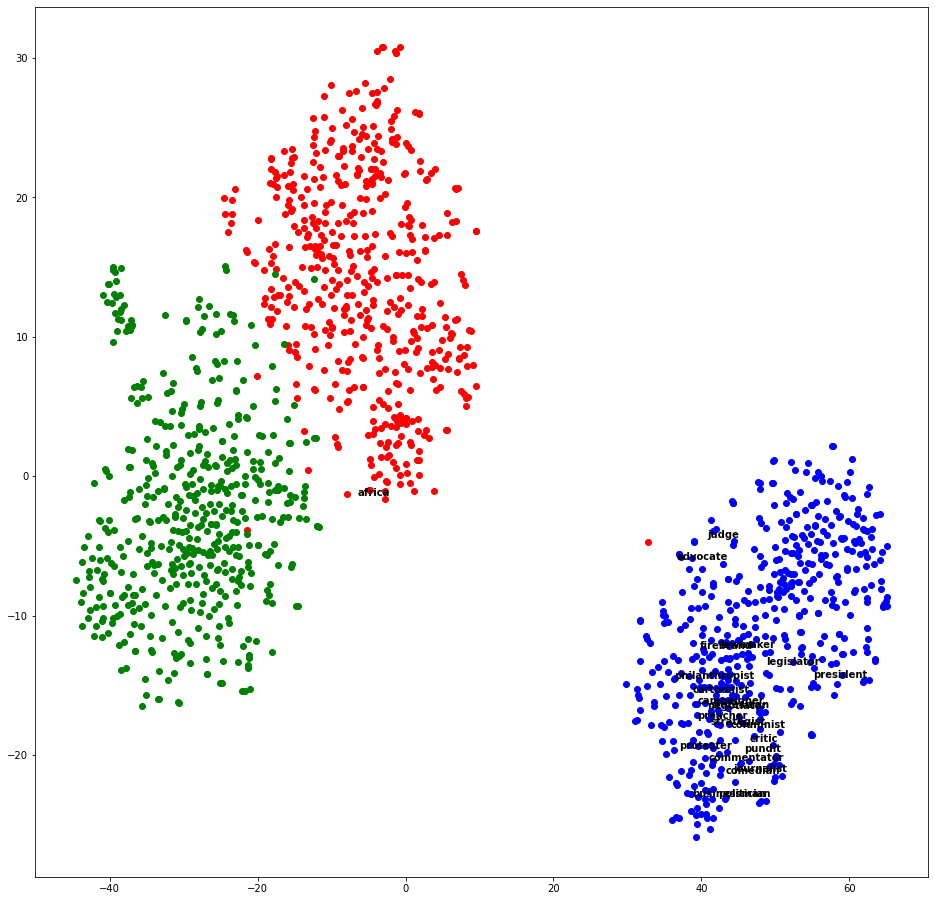

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'america', 'asia']:


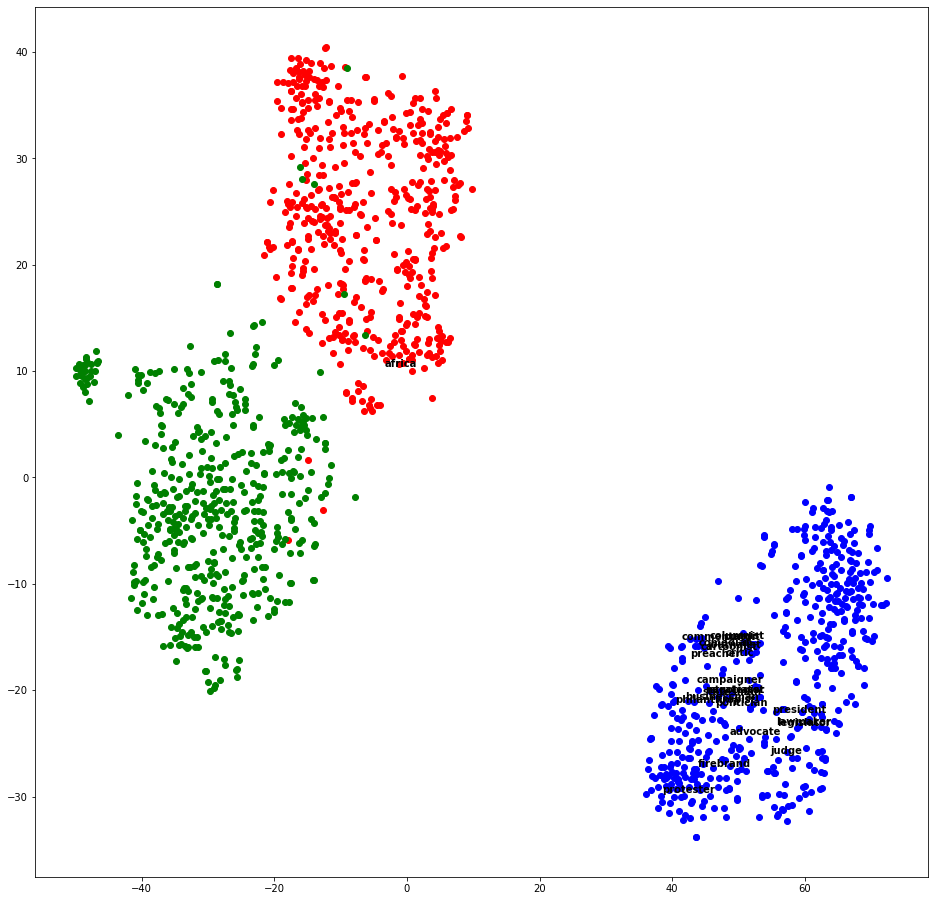


tSNE Clustering Plot (Original Embedding): ['africa', 'america', 'china']:


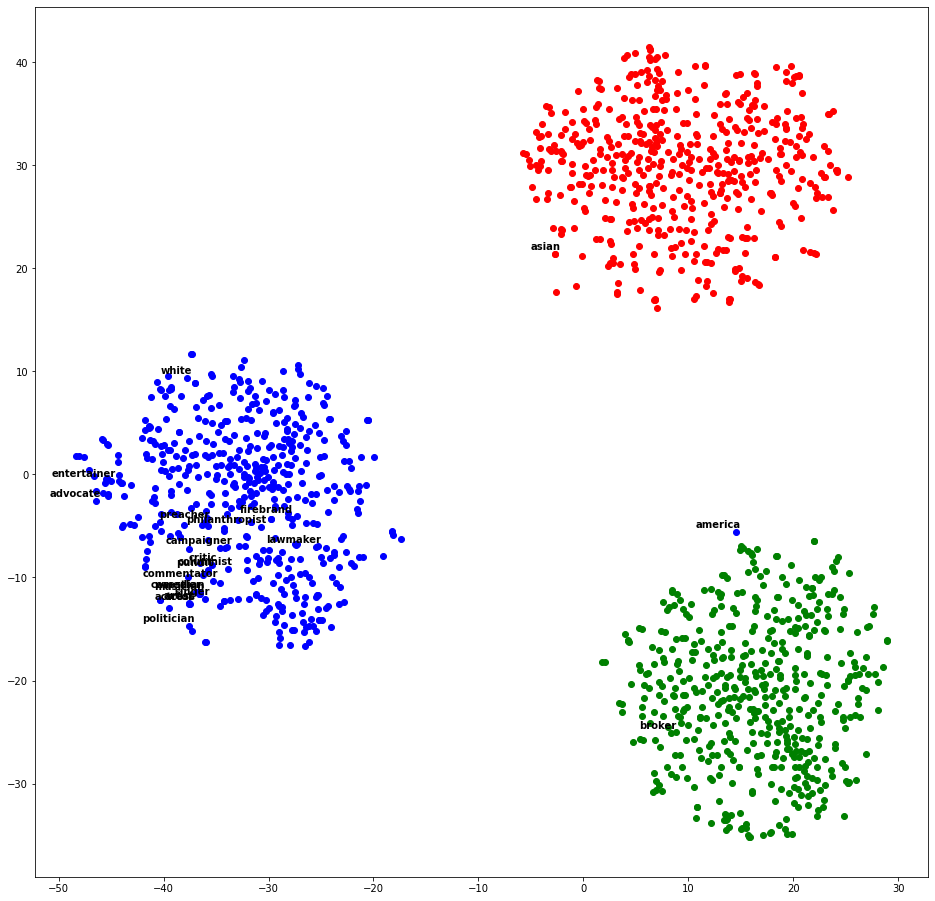

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'america', 'china']:


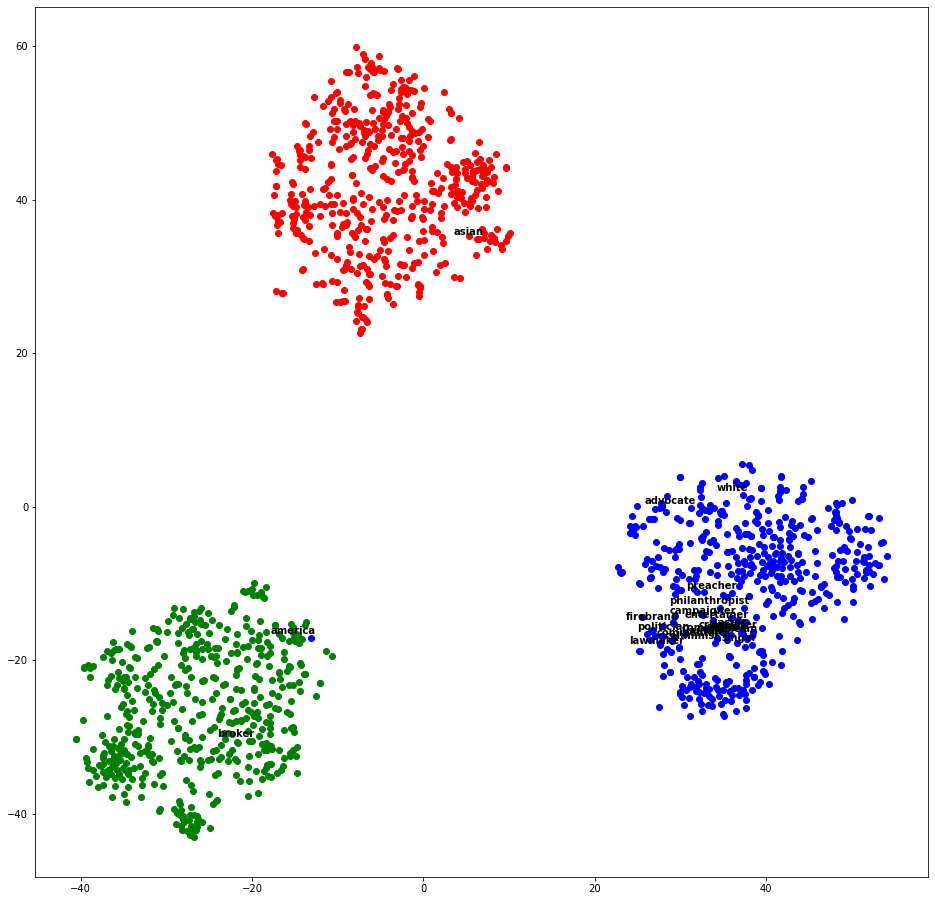


tSNE Clustering Plot (Original Embedding): ['africa', 'europe', 'asia']:


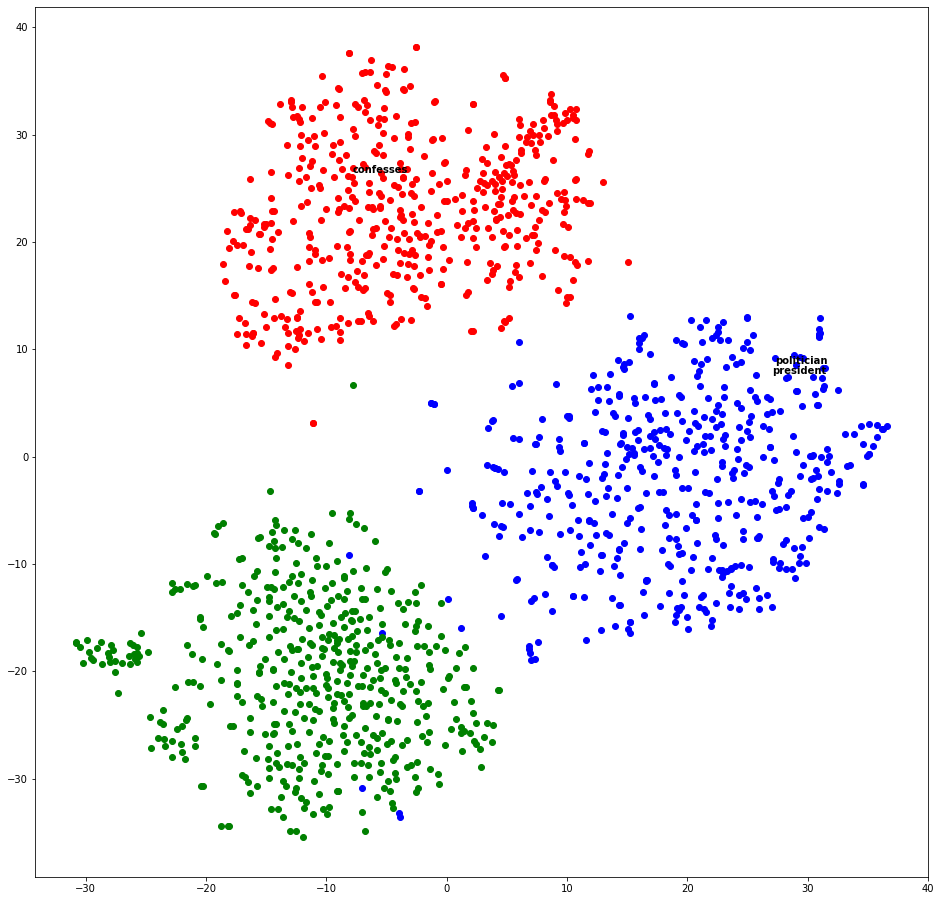

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'europe', 'asia']:


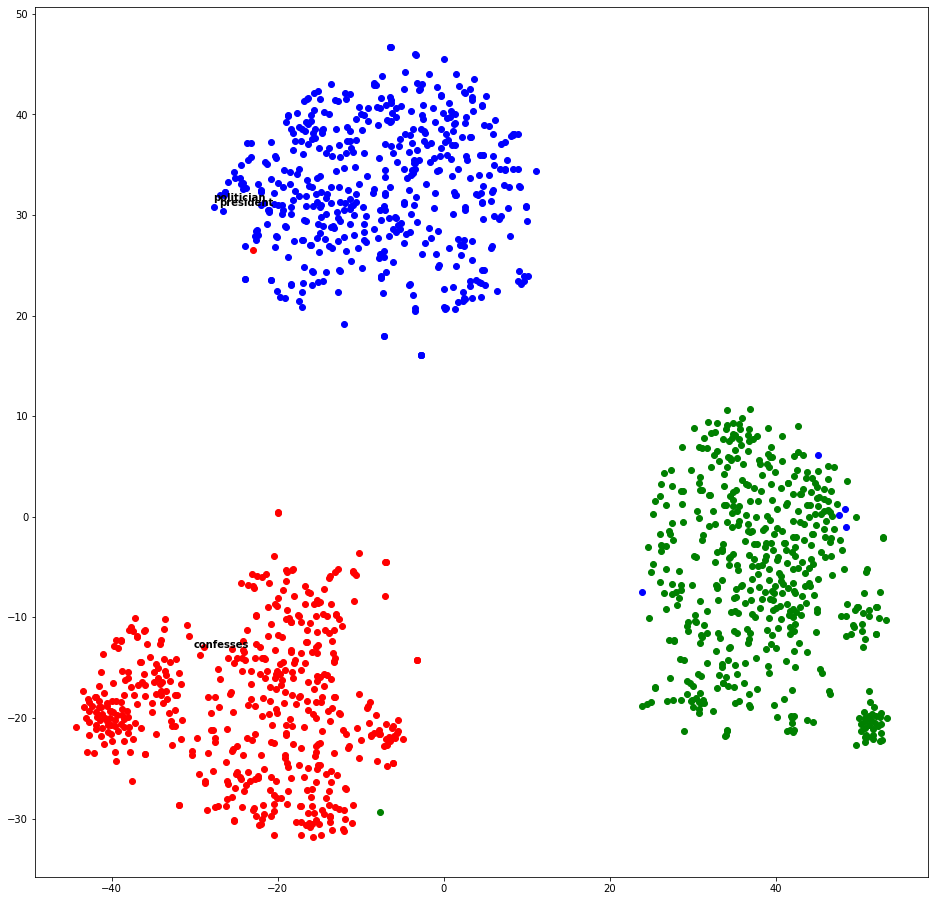

In [9]:
import warnings
warnings.filterwarnings('ignore')

defined_sets = range(0, len(def_sets))

num_words = 500

for d in defined_sets:
    classes = def_sets[d] 
    # Get the subspace/direction for this defined set group
    directions = get_race_directions(classes, embed_dim, original_vectors)
    # Use the original model to determine the words that have strong positive biases 
    # for each class in the subspace
    positive_words, _ = generate_max_biased_words(original_vectors, directions, num_words)
    
    # Flatten positive words to list of words
    biased_words = [ word for _, words in positive_words.items() for word in words]
    # Flatten class values for strong biased words (this will be used for coloring plot)
    color_classes = [ i for i, (_, words) in enumerate(positive_words.items()) for _ in words]

    print(f"\ntSNE Clustering Plot (Original Embedding): {def_sets[d]}:")
    tsne_plot(wv_pt, biased_words, set(target_words), color_classes)   
    
    print(f"tSNE Clustering Plot (Hard Debiased Embedding): {def_sets[d]}:")
    tsne_plot(wv_hd, biased_words, set(target_words), color_classes) 
    

In [7]:
defined_sets = range(0, len(def_sets))

# Demonstrate that hard debias will reduce number of prediction capabilities for bias (showing that hard debiass is effective)
num_words = 200

for d in defined_sets:
    classes = def_sets[d] 
    # Get the subspace/direction for this defined set group
    directions = get_race_directions(classes, embed_dim, original_vectors)
    # Use the original model to determine the words that have strong positive biases 
    # for each class in the subspace
    positive_words, _ = generate_max_biased_words(original_vectors, directions, num_words)
    
    x_orig = []
    x_hd = []
    y_true = []

    # for each word in each class, get embeddings based on the original and hard debias model
    for i, (_, items) in enumerate(positive_words.items()):
        for word in items :
            y_true.append(i)
            x_orig.append(original_vectors[word])
            x_hd.append(debiased_vectors[word])

    print(f"K-Means Using Strong Bias for Set Values: {def_sets[d]}:")
    precision_orig = cluster(X1=np.array(x_orig), random_state=3, y_true=y_true, num=3)
    precision_hd = cluster(X1=np.array(x_hd), random_state=3, y_true=y_true, num=3)
    print(f"Original Precision: {precision_orig}, Hard Debias Precision: {precision_hd}, Delta: {precision_orig - precision_hd}")


K-Means Using Strong Bias for Set Values: ['black', 'caucasian', 'asian']:
Original Precision: 0.6666666666666667, Hard Debias Precision: 0.6716666666666666, Delta: -0.004999999999999893
K-Means Using Strong Bias for Set Values: ['african', 'caucasian', 'asian']:
Original Precision: 0.9983333333333333, Hard Debias Precision: 0.6666666666666667, Delta: 0.33166666666666655
K-Means Using Strong Bias for Set Values: ['black', 'white', 'asian']:
Original Precision: 0.9816666666666667, Hard Debias Precision: 0.685, Delta: 0.29666666666666663
K-Means Using Strong Bias for Set Values: ['africa', 'america', 'asia']:
Original Precision: 0.9983333333333333, Hard Debias Precision: 0.9983333333333333, Delta: 0.0
K-Means Using Strong Bias for Set Values: ['africa', 'america', 'china']:
Original Precision: 1.0, Hard Debias Precision: 1.0, Delta: 0.0
K-Means Using Strong Bias for Set Values: ['africa', 'europe', 'asia']:
Original Precision: 1.0, Hard Debias Precision: 1.0, Delta: 0.0
